In [1]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pandas import read_csv
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time


DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [2]:
ibc_df = read_csv("merged_ibc_with_redshift.csv")
ia_df = read_csv("merged_modelpar_Ia_with_redshift.csv")

In [3]:
ibc_df.head()

,object_id,true_z,submodel,sim_av,IBC_INDEX,Mejecta,Kinetic_energy,F_nickel
0,268,0.621,2,0.1007,569,4.0460,1.3293,0.0744
1,1304,0.309,2,0.8308,577,6.1297,2.4682,0.0565
2,1660,0.817,2,0.0018,670,9.8119,4.1647,0.0849
3,2407,0.586,2,0.0108,500,1.1125,7.1842,0.0801
4,3073,0.441,2,0.2936,395,2.0126,3.4670,0.0448


In [29]:
class ArnettSource(sncosmo.Source):

    _param_names = ['texp', 'mej', 'fni', 'vej']
    param_names = ['texp', 'mej', 'fni', 'vej']

    param_names_latex = ['t_{exp}', 'M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, redshift,  params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._z = redshift
        # self._texp = texp
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, redshift, theta):
        texp, mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        mni = mej * fni
        # Convert velocity to cm/s
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g        
        texp = texp * u.day

        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
        # print(mej.to(u.Msun), vej, td)
        # if td < 3. * u.day:
        #     td = 3. * u.day
        # print(td)

        # use a denser time array for better integration
        t_to_integrate = np.linspace(0, np.max(t - texp), 1000)
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        spline = CubicSpline(t_to_integrate, dense_luminosities, extrapolate = False)
        luminosities = spline(t - texp) * u.erg / u.s # interpolate back from dense time array to original time points

        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)

        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        # fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density
        
        fluxes = self._blackbody_flux(temperature, radius, wvs / (1 + redshift)) # this is a luminosity density

        fluxes[t < texp,:] = 0.* u.kg *u.m / u.s**3
        fluxes[t < 0,:] = 0.* u.kg *u.m / u.s**3


        
        # divide luminosity density by 4pir^2 to get flux
        z = redshift * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density / (1 + redshift)


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._z, self._parameters)

In [30]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

# zeropoints from https://smtn-002.lsst.io/
zeropoints = [28.51, 28.36, 28.17, 27.78]
# LSST sky brightness in mag/arcsec^2 (from SMTN-002 official values)
sky_brightness_mag = [22.25, 21.2, 20.46, 19.61]  # g, r, i, z bands

# LSST observing parameters (from official LSST specs)
exptime = 30.0  # seconds per visit (2x15s exposures)
pixel_scale = 0.2  # arcseconds per pixel (LSST camera)
aperture_radius = 1.0  # arcseconds (typical PSF aperture, will be calculated properly)
read_noise = 8.8  # electrons per pixel per exposure
dark_current = 0.2  # electrons per pixel per second
num_bands = len(bands)

# Convert sky brightness to sky noise (electrons/pixel/second)
# Using LSST effective area = 6.423m diameter, pixel scale = 0.2 arcsec/pixel
# Sky noise = sky_flux * effective_area * pixel_area / exposure_time
# For now, using approximate values - these should be calculated more precisely
sky_noise = 10**(-0.4*(np.asarray(sky_brightness_mag) - np.asarray(zeropoints))) * pixel_scale**2  # g, r, i, z bands (electrons/pixel/second)


ia_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})

ibc_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})



In [31]:
def simulate_ibc(true_z, texp, mej, fni, vej):
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[mej, fni, vej])
    arnett_source = ArnettSource(times, wavelengths, true_z, params=[texp, mej, fni, vej])

    
    arnett_model = sncosmo.Model(source=arnett_source)
    params = {'texp': texp, 'mej': mej, 'fni': fni, 'vej': vej}

    lcs = sncosmo.realize_lcs(ibc_obs, arnett_model, [params])
    
    r_band_mask = lcs[0]['band'] == 'lsstr'

    
    # calculate SNR in r band
    # snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    # print("SNR:", snr)
    # mej = (mej * u.Msun).to(u.g)
    # vej = vej * u.km/u.s
    # opac = 0.1 *u.cm * u.cm/u.g        

    # Diffusion timescale in days
    # td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
    # print(td)
    # lcs[0]['flux'][lcs[0]['flux'] <= 0] = 0.1
    return lcs

4.001503675913365


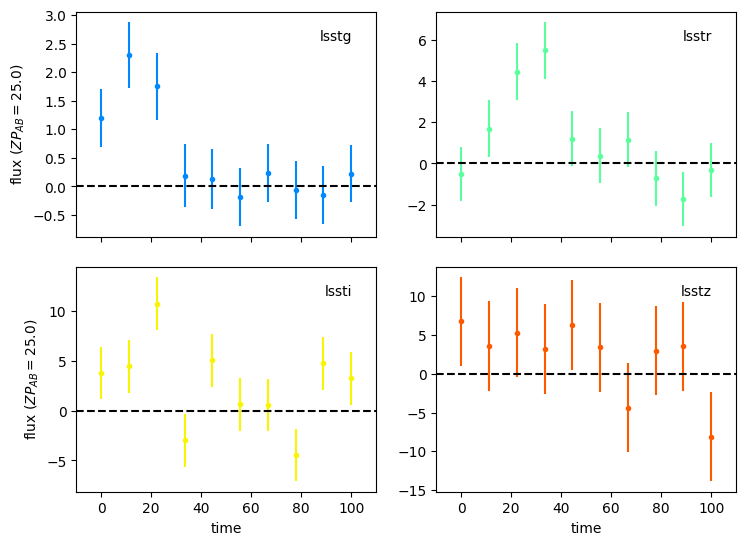

In [32]:
# light_curve = simulate_ibc(0.05, 0, 3, 0.1, 10000)
# light_curve = simulate_ibc(0.116, 5.76, 0.4841, 0.0309, 37270.73384139233)
# light_curve = simulate_ibc(0.116, 2.4, 0.4841, 0.0309, 37270.73384139233)

light_curve = simulate_ibc(0.18, -2, 5.4863 , 0.0456, 10416.298485236222)
r_band_mask = light_curve[0]['band'] == 'lsstr'
print(np.max(light_curve[0]["flux"][r_band_mask] / light_curve[0]["fluxerr"][r_band_mask]))


sncosmo.plot_lc(light_curve[0]);

In [33]:
def get_texp_guess(light_curve):
    max_index = np.argmax(light_curve[0]['flux'][light_curve[0]['band'] == 'lssti'])
    print(max_index)
    max_time = (light_curve[0]['time'][light_curve[0]['band'] == 'lssti'])[max_index]
    print((light_curve[0]['time'][light_curve[0]['band'] == 'lssti']))
    print(max_time)
    return max_time - 5.

In [37]:
def fit_ibc(true_z, lcs):

    arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 3, 0.05, 15000]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                          bounds={'texp':(-3, 14), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 0.5, 0.1, 20000]) # initial parameter values? not sure why these are needed...
        arnett_model = sncosmo.Model(source=arnett_source)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                  bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                 minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [38]:
def td(mej, vej):
    mej = (mej * u.Msun).to(u.g)
    vej = vej * u.km/u.s
    # Diffusion timescale in days
    opac = 0.1 *u.cm * u.cm/u.g        
    td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day) 
    return td

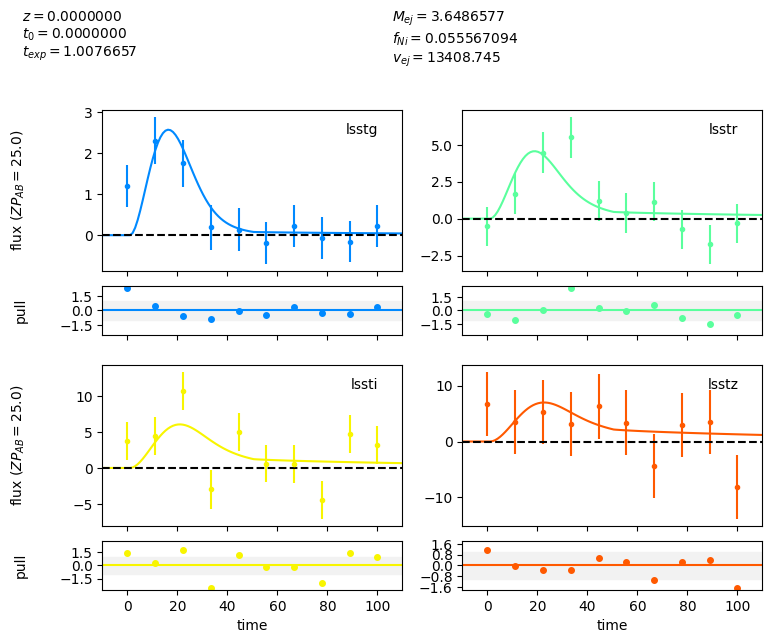

In [39]:
result, fitted_model = fit_ibc(0.18, light_curve)
sncosmo.plot_lc(light_curve[0], model=fitted_model);

In [40]:
num_to_fit = 10
fits = {'true_z': [], 'true_texp': [], 'true_mej': [], 'true_fni': [], 'true_vej':[], 'fit_texp':[], 'fit_mej':[], 'fit_fni':[], 'fit_vej':[]}

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = ((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)
    
    this_texp = np.random.uniform(0., 7.)
    # if true_z > 0.2 or vej.value > 20000:
    #     continue
    
    try:
        lcs = simulate_ibc(true_z, this_texp, mej, fni, vej.value)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("Wrong SNR:", peak_snr)
            continue
        print("SNR:", peak_snr)
        # sncosmo.plot_lc(lcs[0])

        result, fitted_model = fit_ibc(true_z, lcs)
        # sncosmo.plot_lc(lcs[0], model=fitted_model)
        # plt.show()
        result_dict = sncosmo.flatten_result(result)
        fits['true_z'].append(true_z)
        fits['true_texp'].append(this_texp)
        fits['true_mej'].append(mej)
        fits['true_fni'].append(fni)
        fits['true_vej'].append(vej.value)
        fits['fit_texp'].append(result_dict['texp'])
        fits['fit_mej'].append(result_dict['mej'])
        fits['fit_fni'].append(result_dict['fni'])
        fits['fit_vej'].append(result_dict['vej'])
    except Exception as e:
        print(e)

    if len(fits['fit_mej']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

Wrong SNR: 1.1640799605405574
Wrong SNR: 2.3058759250198233
Wrong SNR: 1.4064828697846263
Wrong SNR: 1.5097350662448685
Wrong SNR: 1.2994057830850472
Wrong SNR: 1.0621183531280087
Wrong SNR: 3.4971626949549743
Wrong SNR: 2.507294661975523
Wrong SNR: 1.4610732478160713
Wrong SNR: 0.9156274980446739
Wrong SNR: 1.105395238063436
Wrong SNR: 2.0757875311196785
Wrong SNR: 2.2626676464093687
Wrong SNR: 1.854249873913591
Wrong SNR: 3.156528019663052
Wrong SNR: 0.8856902801943961
Wrong SNR: 0.41659343221339534
Wrong SNR: 1.361944770748681
Wrong SNR: 1.3712146714753073
Wrong SNR: 1.502718340542936
Wrong SNR: 1.058932185579299
Wrong SNR: 2.1017546567833745
Wrong SNR: 2.0705264736649385
Wrong SNR: 2.3313097537304825
Wrong SNR: 1.0531563931074275
Wrong SNR: 1.6985408186699318
Wrong SNR: 2.1195438704609124
Wrong SNR: 1.376555637565376
Wrong SNR: 1.4973287524787449
Wrong SNR: 1.962435138618696
Wrong SNR: 2.017758272217922
Wrong SNR: 2.151414367417289
Wrong SNR: 1.8254918006919638
Wrong SNR: 1.2642531

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Wrong SNR: 1.4848792180916692
Wrong SNR: 1.307815642189726
Wrong SNR: 1.3782117708176438
Wrong SNR: 2.443447086892856
Wrong SNR: 2.729141671554827
Wrong SNR: 1.1276614982184712
Wrong SNR: 0.9926765373954137
Wrong SNR: 2.4609278324148542
Wrong SNR: 3.1917284763784624
Wrong SNR: 0.6082115639982335
Wrong SNR: 1.6677222689599092
Wrong SNR: 1.3918872928247852
Wrong SNR: 1.377204848839949
Wrong SNR: 1.7250088442930527
Wrong SNR: 2.0071882252182545
Wrong SNR: 1.6177488278375414
Wrong SNR: 1.9378380549285936
Wrong SNR: 2.306975836395144
Wrong SNR: 1.4402163854704555
Wrong SNR: 1.5770190569711167
Wrong SNR: 1.1471613099851616
Wrong SNR: 0.3556219510788257
Wrong SNR: 2.828295311956455
Wrong SNR: 1.801656504112596
Wrong SNR: 3.150434392594096
Wrong SNR: 2.0486966780741316
Wrong SNR: 0.9893792603203353
Wrong SNR: 0.8703202115002887
Wrong SNR: 1.4371273447371005
Wrong SNR: 1.6064076564114786
Wrong SNR: 0.8545686462981097
Wrong SNR: 2.1321374087643337
Wrong SNR: 1.5224836471555006
Wrong SNR: 1.85008

Text(0, 0.5, 'Fit texp')

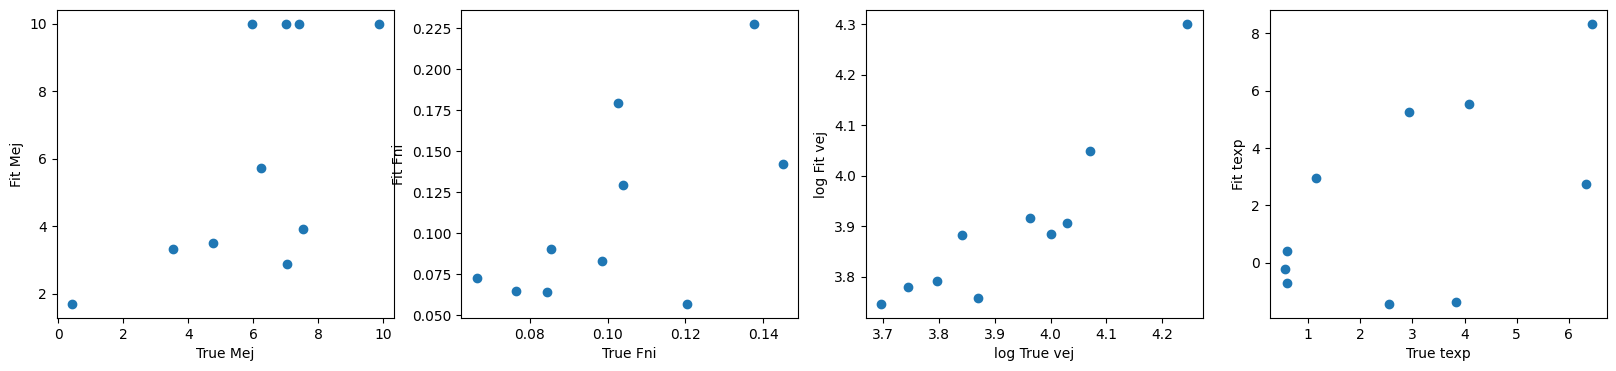

In [41]:
fig, ax = plt.subplots(1,4, figsize=(20, 4))

ax[0].plot(fits['true_mej'], fits['fit_mej'], 'o')
ax[0].set_xlabel("True Mej")
ax[0].set_ylabel("Fit Mej")
ax[1].plot(fits['true_fni'], fits['fit_fni'], 'o')
ax[1].set_xlabel("True Fni")
ax[1].set_ylabel("Fit Fni")
ax[2].plot(np.log10(fits['true_vej']), np.log10(fits['fit_vej']), 'o')
ax[2].set_xlabel("log True vej")
ax[2].set_ylabel("log Fit vej")
ax[3].plot(fits['true_texp'], fits['fit_texp'], 'o')
ax[3].set_xlabel("True texp")
ax[3].set_ylabel("Fit texp")

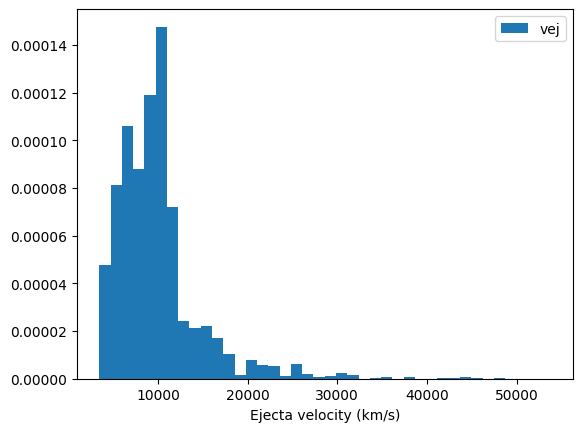

In [42]:
vej = np.sqrt(
    2 * ibc_df['Kinetic_energy'].values * 1e51 * u.erg / (ibc_df['Mejecta'].values * u.Msun)
)
vej = vej.to(u.km / u.s)
plt.hist(vej.value, bins=40, density=True, label="vej")
plt.xlabel("Ejecta velocity (km/s)")
plt.legend()


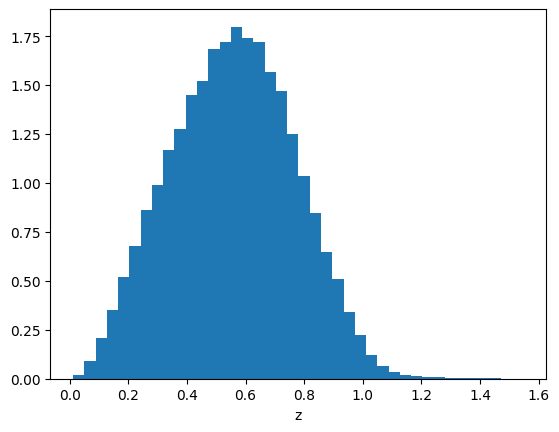

In [43]:
plt.hist(ia_df['true_z'].to_numpy(), bins=40, density=True)
plt.xlabel("z")
plt.show()

In [44]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [45]:
get_x0(np.min(ia_df['salt2_mb'].to_numpy())), get_x0(np.max(ia_df['salt2_mb'].to_numpy()))

(0.047363086913163675, 7.842959998847406e-07)

In [46]:
np.min(ia_df['salt2_color'].to_numpy()), np.max(ia_df['salt2_color'].to_numpy())

(-0.2673, 0.3732)

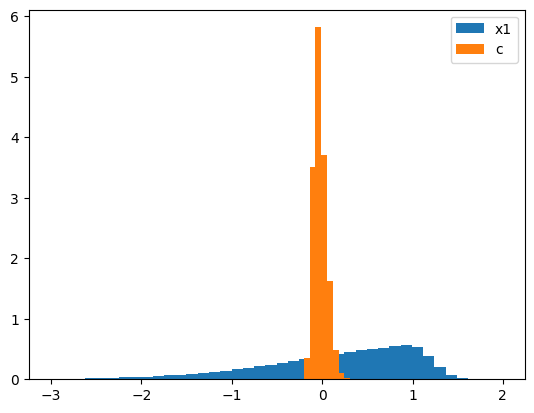

In [47]:
plt.hist(ia_df['salt2_x1'].to_numpy(), bins=40, density=True, label="x1")
plt.hist(ia_df['salt2_color'].to_numpy(), density=True, label="c")
plt.legend()

In [53]:
def simulate_ia(true_z, t0, x0, x1, c):
    params = {'z': true_z, 't0': t0, 'x0':x0, 'x1': x1, 'c':c}
    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')

    this_ia_model = sncosmo.Model(source=ia_source)

    lcs = sncosmo.realize_lcs(ia_obs, this_ia_model, [params])

    intrinsic_scatter_mag = 0.1  # e.g., 0.1 mag scatter

    # Add intrinsic scatter to the flux uncertainties (likelihood)
    for lc in lcs:
        # Convert mag scatter to flux scatter (fractional)
        frac_scatter = 10**(0.4 * intrinsic_scatter_mag) - 1
        # Add in quadrature to the fluxerr
        lc['fluxerr'] = np.sqrt(lc['fluxerr']**2 + (frac_scatter * lc['flux'])**2)

    # r_band_mask = lcs[0]['band'] == 'lsstr'
    # snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    # print("SNR:", snr)

    return lcs

In [54]:
def fit_ia(true_z, lcs):

    # this_ia_model = sncosmo.Model(source='salt2')
    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [55]:
# light_curve = simulate_ia(0.624, 20, get_x0(23.7568), -0.3504, 0.0744)
light_curve = simulate_ia(0.2, 20, get_x0(23.7568), -0.3504, 0.0744)

2.35212867702613


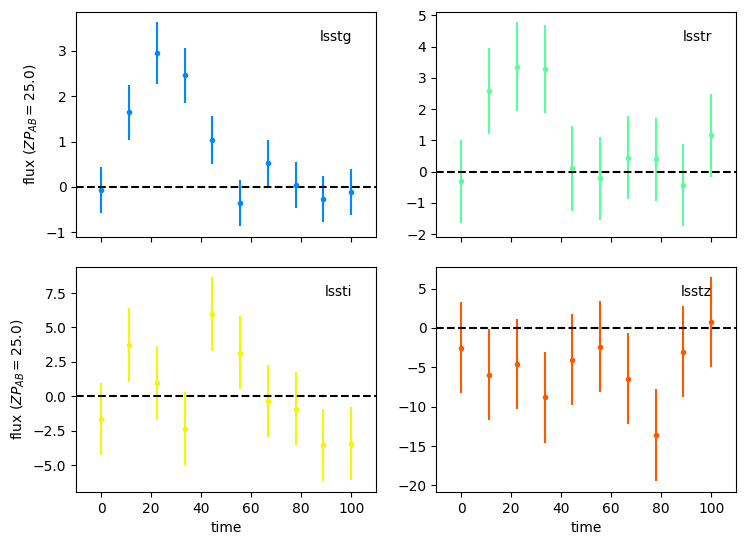

In [56]:
sncosmo.plot_lc(light_curve[0]);
print(np.max(light_curve[0]["flux"][r_band_mask] / light_curve[0]["fluxerr"][r_band_mask]))



/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


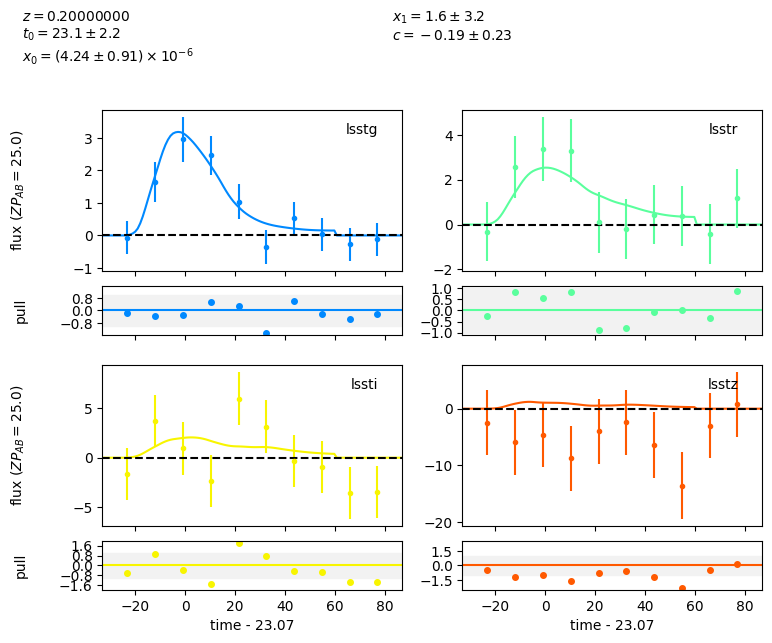

In [57]:
ia_result, ia_fitted_model = fit_ia(0.2,light_curve)
# ibc_result, ibc_fitted_model = fit_ibc(0.274,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

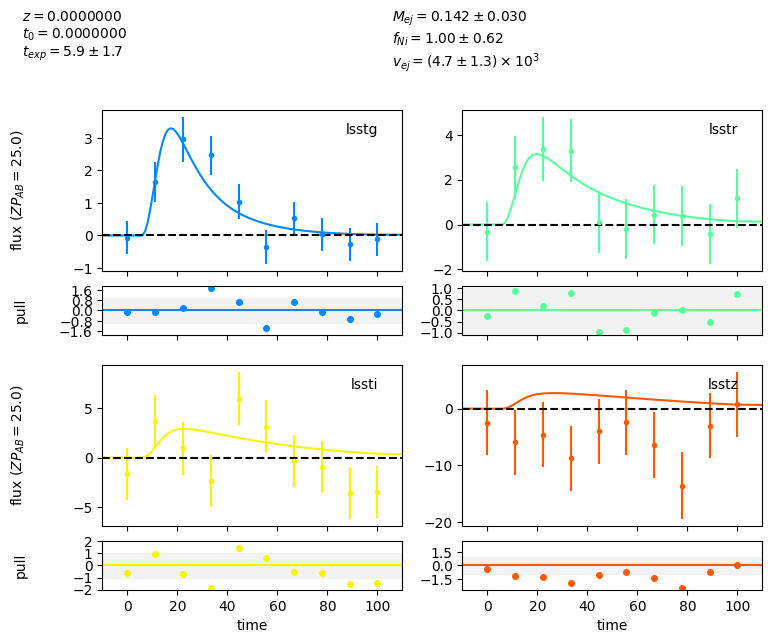

In [58]:
ibc_result, ibc_fitted_model = fit_ibc(0.2,light_curve)
# ibc_result, ibc_fitted_model = fit_ibc(0.274,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

9.910917545276126


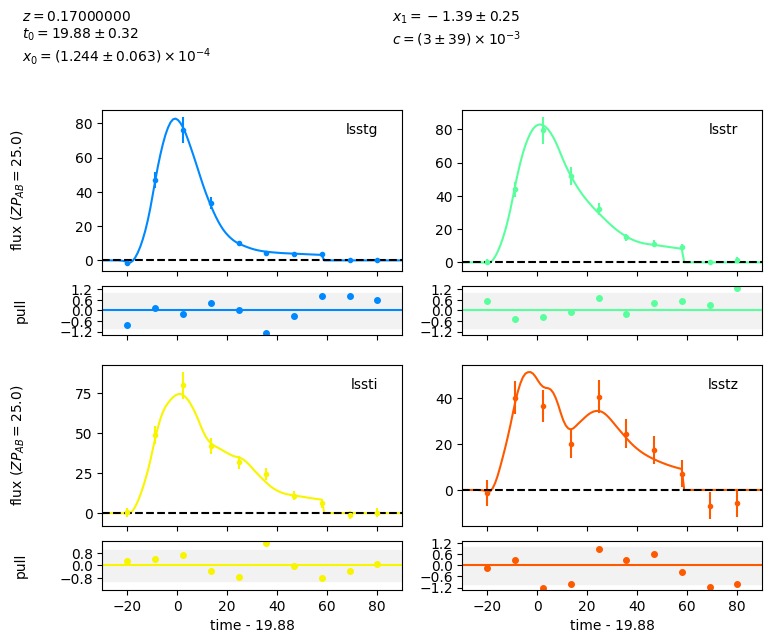

In [59]:
light_curve = simulate_ia(0.17, 20, get_x0(20.3969), -1.3166, 0.0048)
print(np.max(light_curve[0]["flux"][r_band_mask] / light_curve[0]["fluxerr"][r_band_mask]))
ia_result, ia_fitted_model = fit_ia(0.17,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

In [60]:
light_curve

[<Table length=40>
        time         band        flux             fluxerr          zp   zpsys
      float64        str5      float64            float64       float64  str2
 ------------------ ----- ------------------ ------------------ ------- -----
               0.01 lsstg  -38.1401705322676 14.140577794536556   28.51    ab
              11.12 lsstg 1192.8836809291738 120.72279694537102   28.51    ab
              22.23 lsstg 1929.3818882959729 191.81100643133516   28.51    ab
 33.339999999999996 lsstg  854.1180777550265  88.25119517194734   28.51    ab
 44.449999999999996 lsstg 251.46457577106398 31.790600926819657   28.51    ab
 55.559999999999995 lsstg 103.42088740883928 19.850416380963395   28.51    ab
              66.67 lsstg  94.19302716461458 18.617448039365758   28.51    ab
              77.78 lsstg  95.61940650548739  18.17043569492284   28.51    ab
              88.89 lsstg 10.523927132540217 12.806463840365772   28.51    ab
              100.0 lsstg  7.462793997161622 

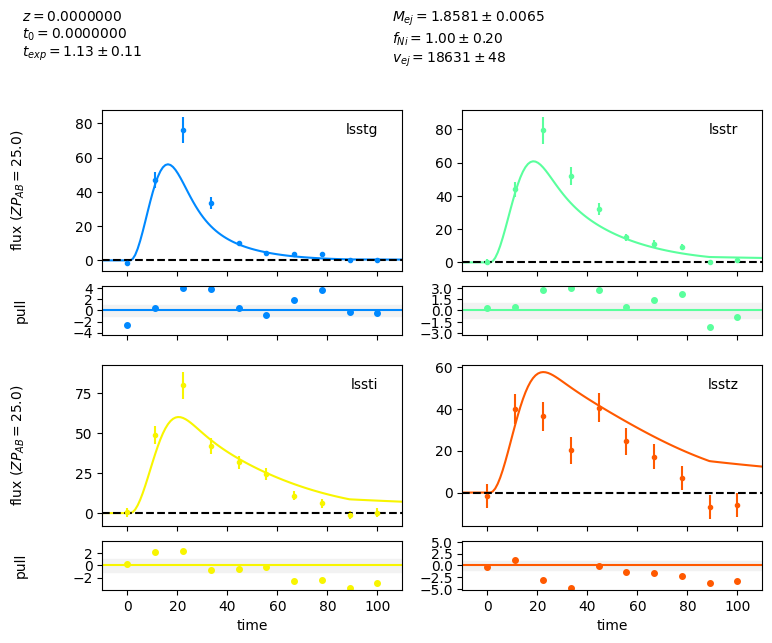

In [61]:
ibc_result, ibc_fitted_model = fit_ibc(0.17,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

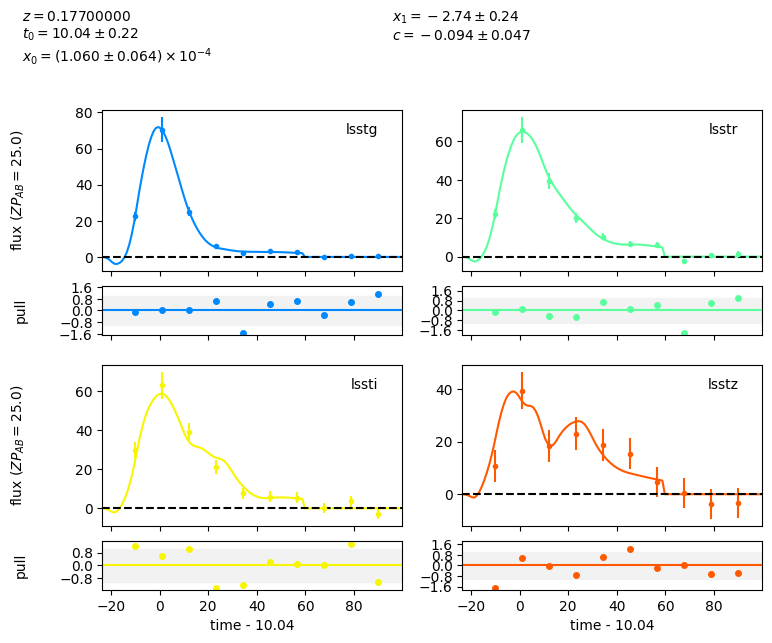

In [62]:
light_curve = simulate_ia(0.177, 10, get_x0(20.5669), -2.872, -0.0432)
ia_result, ia_fitted_model = fit_ia(0.177,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...


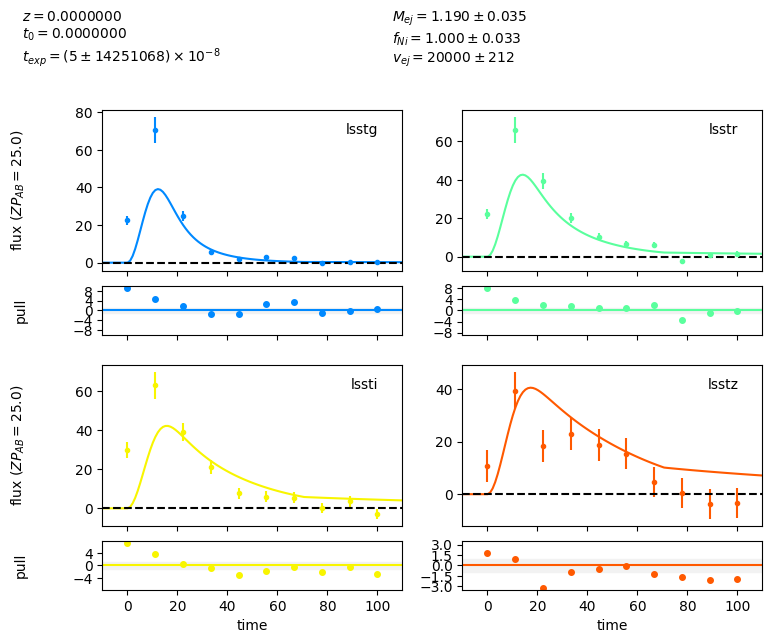

In [63]:
ibc_result, ibc_fitted_model = fit_ibc(0.177,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

In [64]:
num_to_fit = 100

bad_count = 0
good_count = 0

fits = {'true_z': [], 'true_t0': [], 'true_x0': [], 'true_x1':[], 'true_c':[], 'fit_t0':[], 'fit_x0':[], 'fit_x1':[], 'fit_c':[]}

# t0 = 20

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    
    # if true_z > 0.2:
    #     continue
    try:
        this_t0 = np.random.normal(14., 7.)
        # print(true_z, this_t0)
        lcs = simulate_ia(true_z, this_t0, x0, x1, c)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("Bad SNR:", peak_snr)
            bad_count += 1
            continue
        print("OK SNR:", peak_snr)
        good_count += 1

        result, model = fit_ia(true_z, lcs)

        result_dict = sncosmo.flatten_result(result)
        fits['true_z'].append(true_z)
        fits['true_t0'].append(this_t0)
        fits['true_x0'].append(x0)
        fits['true_x1'].append(x1)
        fits['true_c'].append(c)
        fits['fit_t0'].append(result_dict['t0'])
        fits['fit_x0'].append(result_dict['x0'])
        fits['fit_x1'].append(result_dict['x1'])
        fits['fit_c'].append(result_dict['c'])
    except:
        print(true_z, "Did not work")

    if len(fits['fit_x0']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)
print("Good fits:", good_count, "Bad fits:", bad_count)

Bad SNR: 3.6881270599613565
OK SNR: 7.491742335749451
Bad SNR: 3.1505876465612777
Bad SNR: 2.9058052413277067
Bad SNR: 2.2666657467340285
Bad SNR: 2.8759580258058177
Bad SNR: 1.0598824498434212
OK SNR: 9.105657656591953
Bad SNR: 3.5747542165072312
OK SNR: 7.024793378079391
Bad SNR: 2.5999694002927156
OK SNR: 7.6809720221860305
OK SNR: 6.258115136046441
Bad SNR: 3.708367046190465
Bad SNR: 3.438440325032765
Bad SNR: 1.9563438295423303
Bad SNR: 2.4365941410917045
Bad SNR: 2.3939932627738845
Bad SNR: 2.287531942172293
Bad SNR: 2.550414224100231
Bad SNR: 2.397124733269383
Bad SNR: 4.5370542337647
OK SNR: 6.657356138659555
Bad SNR: 1.191402351707023
Bad SNR: 4.9279910728735725
Bad SNR: 1.5930864412938786
Bad SNR: 1.0586553880323109
Bad SNR: 1.9654476090703072
Bad SNR: 1.4892050166615927
Bad SNR: 0.9083229144689448
OK SNR: 7.503843731706037
Bad SNR: 4.0447388135034945
Bad SNR: 1.7933359062524121
Bad SNR: 4.9003119559862265
Bad SNR: 4.804848447242741
Bad SNR: 1.6233546228579672
Bad SNR: 1.6083

Text(0, 0.5, 'Fit t0')

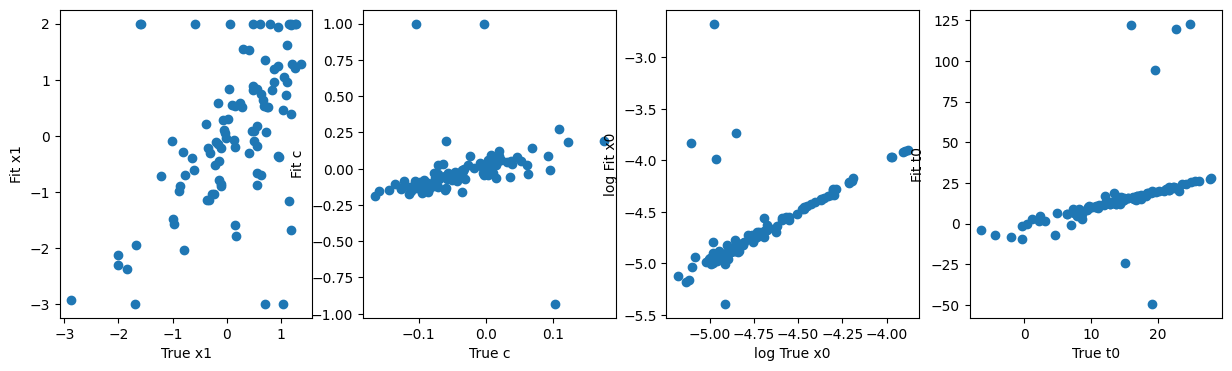

In [65]:
fig, ax = plt.subplots(1,4, figsize=(15, 4))

ax[0].plot(fits['true_x1'], fits['fit_x1'], 'o')
ax[0].set_xlabel("True x1")
ax[0].set_ylabel("Fit x1")
ax[1].plot(fits['true_c'], fits['fit_c'], 'o')
ax[1].set_xlabel("True c")
ax[1].set_ylabel("Fit c")
ax[2].plot(np.log10(fits['true_x0']), np.log10(fits['fit_x0']), 'o')
ax[2].set_xlabel("log True x0")
ax[2].set_ylabel("log Fit x0")
ax[3].plot(fits['true_t0'], fits['fit_t0'], 'o')
ax[3].set_xlabel("True t0")
ax[3].set_ylabel("Fit t0")

In [66]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
            


In [67]:
SN('ia', {'z':0.6, 't0':20, 'x0':1e-5, 'x1':0.1, 'c':0.1}).true_class

'ia'

In [68]:
num_to_fit = 100

# t0 = 20
bad_count = 0
good_count = 0

true_ia_sne = []

# fit true Ias as both
start = time.time()
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    # if true_z > 0.2:
    #     continue
    
    try:
        this_t0 = np.random.normal(14., 7.)
        # print(true_z, this_t0)
        
        true_dict = {'z': true_z, 't0':this_t0, 'x0':x0, 'x1':x1, 'c':c}
        this_sn = SN('ia', true_dict)

        lcs = simulate_ia(true_z, this_t0, x0, x1, c)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("Bad SNR:", peak_snr)
            bad_count += 1
            continue
        print("OK SNR:", peak_snr)
        good_count += 1

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)
        # print(sncosmo.flatten_result(ibc_result))
        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))

        true_ia_sne.append(this_sn)
    except Exception as e:
        print(e)

    if len(true_ia_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)
print("Good fits:", good_count, "Bad fits:", bad_count)


Bad SNR: 2.6732543134880693
OK SNR: 7.406240052778604
Bad SNR: 2.5653583091470833
Bad SNR: 1.884736591630076
Bad SNR: 1.996370841224454
Bad SNR: 1.814511329112761
Bad SNR: 2.3506254110356957
OK SNR: 9.070092514038851
Bad SNR: 2.5140438751774656
OK SNR: 5.330324418936004
Bad SNR: 2.6442709751378914
OK SNR: 6.96387264219331
OK SNR: 6.5621173119654355
Bad SNR: 1.9664320930117405
Bad SNR: 4.274096331765128
Bad SNR: 2.6363452402892715
Bad SNR: 2.334084032890947
Bad SNR: 1.975787220887039
Bad SNR: 1.7744749855477153
Bad SNR: 3.3181611275325045
Bad SNR: 2.5551567508745094
Bad SNR: 4.758442721675868
OK SNR: 6.246004428143995
Bad SNR: 2.4375669349865254
OK SNR: 5.931460021518373
Bad SNR: 1.972886144922241
Bad SNR: 2.0115671183723514
Bad SNR: 0.22199424311412752
Bad SNR: 3.3727253355391107
Bad SNR: 1.799244602152282
OK SNR: 7.562010769838433
OK SNR: 5.274373081324921
Bad SNR: 2.409775436156899
Bad SNR: 4.373552313012343
Bad SNR: 4.976003864412195
Bad SNR: 1.621844993840715
Bad SNR: 2.43673794839

In [69]:
true_ibc_sne = []

bad_count = 0
good_count = 0

# Fit ibc as both
start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = (((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)).value
    
    # if true_z > 0.2 or vej > 20000:
    #     continue

    # print(mej, fni, vej)

    
    try:
        this_texp = np.random.uniform(0., 7.)

        true_dict = {'z': true_z, 'texp': this_texp, 'mej':mej, 'fni':fni, 'vej':vej}
        this_sn = SN('ibc', true_dict)
        
        lcs = simulate_ibc(true_z, this_texp, mej, fni, vej)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        peak_snr = np.max(lcs[0]["flux"][r_band_mask] / lcs[0]["fluxerr"][r_band_mask])
        if peak_snr < 5.0 or peak_snr > 10.:
            print("Bad SNR:", peak_snr)
            bad_count += 1
            continue
        print("OK SNR:", peak_snr)
        good_count += 1

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)

        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        true_ibc_sne.append(this_sn)

    except Exception as e:
        print(e)

    if len(true_ibc_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)
print("Good fits:", good_count, "Bad fits:", bad_count)

Bad SNR: 1.7151797564428295
Bad SNR: 1.5514379395766527
Bad SNR: 1.6518714552766336
Bad SNR: 0.832859209353942
Bad SNR: 2.3715641240487435
Bad SNR: 1.6279411824653098
Bad SNR: 4.876547126536424
Bad SNR: 1.2637467193993244
Bad SNR: 2.1076320422441563
Bad SNR: 1.5597307284973616
Bad SNR: 1.4641739889259324
Bad SNR: 2.5819853345069137
Bad SNR: 1.7983429703870124
Bad SNR: 1.7866589632288916
Bad SNR: 3.0323957260333536
Bad SNR: 1.2690050283587166
Bad SNR: 1.4071774618116986
Bad SNR: 1.9259725398374459
Bad SNR: 1.2190186715321465
Bad SNR: 1.7496201487877678
Bad SNR: 2.823854312110184
Bad SNR: 1.2374202483996875
Bad SNR: 2.2056991756757025
Bad SNR: 1.333524890121192
Bad SNR: 2.66279492052585
Bad SNR: 1.2090766731175722
Bad SNR: 1.9942467703150895
Bad SNR: 1.8620141031359771
Bad SNR: 2.610020442583444
Bad SNR: 1.4716543095823287
Bad SNR: 0.7848798626934942
Bad SNR: 0.3530621242114593
Bad SNR: 1.4381362417943016
Bad SNR: 1.3527651586962042
Bad SNR: 1.1089682837979398
Bad SNR: 1.815691934588032


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Bad SNR: 3.2765603763409317
Bad SNR: 1.419709592411416
Bad SNR: 2.1168323372796864
Bad SNR: 3.672288405932375
Bad SNR: 1.152112964380948
Bad SNR: 2.081985208143901
Bad SNR: 2.368602864522479
OK SNR: 6.872842858107047
Bad SNR: 2.4294471032541485
Bad SNR: 0.6083756643405235
Bad SNR: 2.2661787478081696
Bad SNR: 2.1102128042713337
Bad SNR: 2.8262541302763875
Bad SNR: 0.8259997333122242
OK SNR: 7.080169762615033
Bad SNR: 1.6857430033933256
Bad SNR: 1.6636720161414071
Bad SNR: 1.7689334462335977
Bad SNR: 2.287534806634236
OK SNR: 7.311894489709121
Bad SNR: 2.6929341300598173
Bad SNR: 2.6829750110158104
Bad SNR: 1.7195121271513882
Bad SNR: 2.0103358172968866
Bad SNR: 2.2642013014208358
Bad SNR: 1.6738733092700688
Bad SNR: 4.202411280276172
Bad SNR: 3.6964259199390823
Bad SNR: 1.5003514899458463
OK SNR: 5.391614590556525
Bad SNR: 1.603408568296965
Bad SNR: 2.536908178266125
OK SNR: 6.926706584738711
Bad SNR: 1.8407031789386905
Bad SNR: 1.772357092405515
Bad SNR: 2.4706155424120886
Bad SNR: 1.0

In [70]:
# ibc_snrs = []
# with open("output.txt") as f:
#     for line in f:
#         if line.startswith("OK SNR:"):
#             try:
#                 snr = float(line.split(":")[1].strip())
#                 ibc_snrs.append(snr)
#             except ValueError:
#                 continue
# ia_snrs = []

# with open("ia_output.txt") as f:
#     for line in f:
#         if line.startswith("OK SNR:"):
#             try:
#                 snr = float(line.split(":")[1].strip())
#                 ia_snrs.append(snr)
#             except ValueError:
#                 continue
# print(len(ia_snrs), len(ibc_snrs))

# plt.hist(ibc_snrs, bins=30, alpha=0.5,label="true Ibc")
# plt.hist(ia_snrs, bins=30, alpha=0.5, label="true Ia")
# plt.xlabel("SNR")
# plt.ylabel("Count")
# plt.legend()
# plt.show()

In [71]:
np.savez("fitted_sne_100_100125.npz", ia=true_ia_sne, ibc=true_ibc_sne)

In [41]:
all_sne = true_ia_sne + true_ibc_sne
fit_x1 = [sn.ia_fit['x1'] for sn in all_sne]
fit_t0 = [sn.ia_fit['t0'] for sn in all_sne]
fit_c = [sn.ia_fit['c'] for sn in all_sne]
fit_x0 = [sn.ia_fit['x0'] for sn in all_sne]
fit_mej = [sn.ibc_fit['mej'] for sn in all_sne]
fit_fni = [sn.ibc_fit['fni'] for sn in all_sne]
fit_vej = [sn.ibc_fit['vej'] for sn in all_sne]

(array([ 2.,  7.,  5., 50., 73., 44.,  3.,  4.,  1., 11.]),
 array([-59.95941626, -41.55271652, -23.14601677,  -4.73931702,
         13.66738273,  32.07408248,  50.48078222,  68.88748197,
         87.29418172, 105.70088147, 124.10758121]),
 <BarContainer object of 10 artists>)

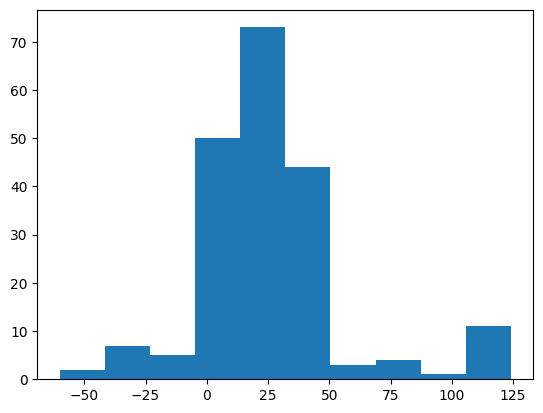

In [42]:
plt.hist(fit_t0)

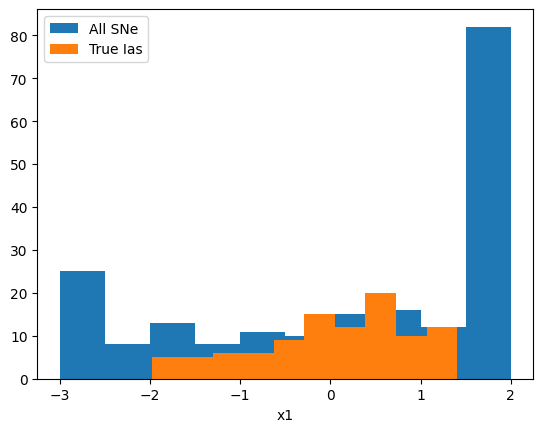

In [43]:
plt.hist(fit_x1, label="All SNe")
plt.hist([sn.true_params['x1'] for sn in true_ia_sne], label="True Ias")
plt.xlabel("x1")
plt.legend()

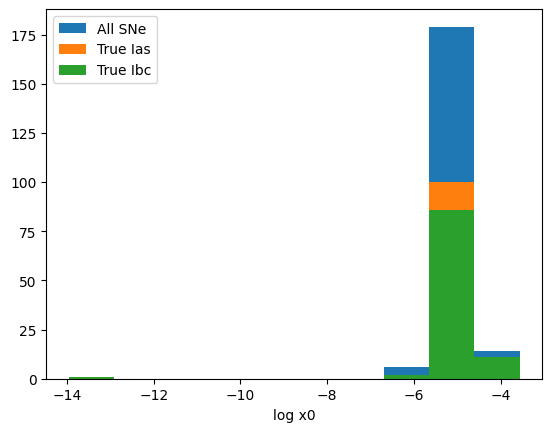

In [44]:
_, bins, _ = plt.hist(np.log10(fit_x0), label="All SNe")
plt.hist(np.log10([sn.true_params['x0'] for sn in true_ia_sne]), label="True Ias", bins=bins)
plt.hist(np.log10([sn.ia_fit['x0'] for sn in true_ibc_sne]), label="True Ibc", bins=bins)

plt.xlabel("log x0")
plt.legend()

In [45]:
ibc_mask = [sn in true_ibc_sne for sn in all_sne]

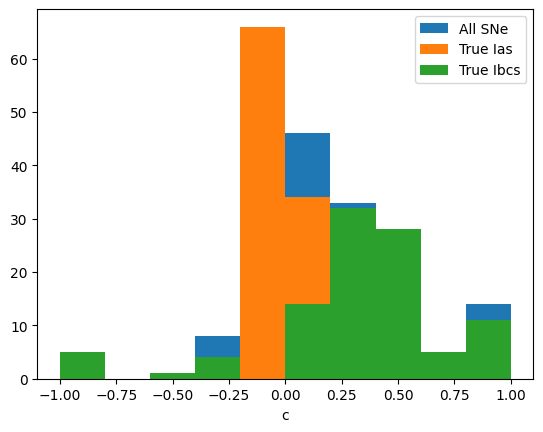

In [46]:
_, bins, _ = plt.hist(fit_c, label="All SNe")
plt.hist([sn.true_params['c'] for sn in true_ia_sne], label="True Ias", bins=bins)
plt.hist(fit_c[(len(fit_c)//2):len(fit_c)], label="True Ibcs", bins=bins)

plt.xlabel("c")
plt.legend()

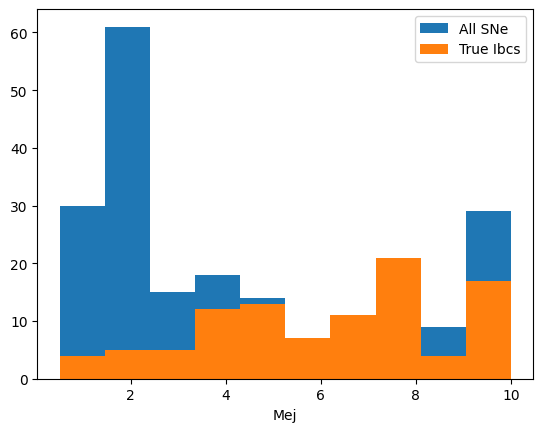

In [47]:
_, bins, _ = plt.hist(fit_mej, label="All SNe")
plt.hist([sn.true_params['mej'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

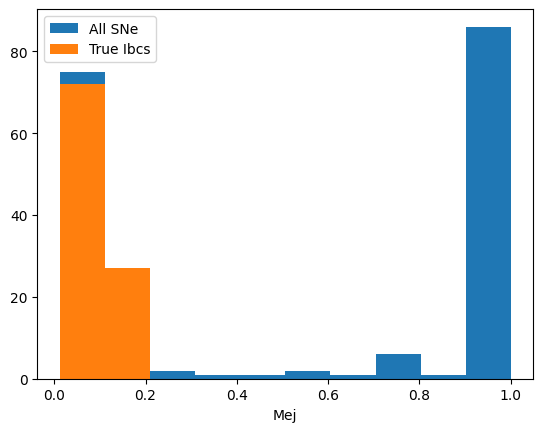

In [48]:
_, bins, _ = plt.hist(fit_fni, label="All SNe")
plt.hist([sn.true_params['fni'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

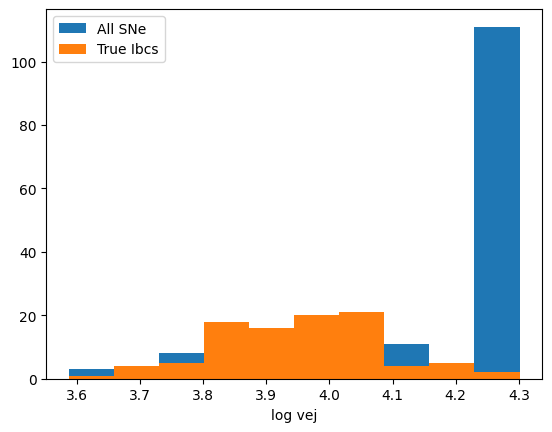

In [49]:
_, bins, _ = plt.hist(np.log10(fit_vej), label="All SNe")
plt.hist(np.log10([sn.true_params['vej'] for sn in true_ibc_sne]), label="True Ibcs", bins=bins)
plt.xlabel("log vej")
plt.legend()